# Suggestion to Reader: Scroll to Bottom _First_

There's one cell that wraps everything together in a concise, functional demo.

In [1]:
%matplotlib notebook

import cv2
import pykitti
import numpy as np
from matplotlib import pyplot as plt

kitti_dir = 'kitti'
kitti_sequence = '04'

kitti = pykitti.odometry(kitti_dir, kitti_sequence)

## Detect Features

In [2]:
def detect_matches_and_E(img1, img2, draw=True):
	# Find Matches
	# From: https://stackoverflow.com/a/33670318
	sift = cv2.SIFT_create()
	kp1, des1 = sift.detectAndCompute(img1, None)
	kp2, des2 = sift.detectAndCompute(img2, None)
	bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
	matches = bf.match(des1, des2)
	matches = sorted(matches, key=lambda x: x.distance)

	if draw:
		match_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, flags=2)
		plt.figure(figsize=(9, 3))
		plt.imshow(match_img)
		plt.show()

	# Find Points
	# From book
	imgpts1 = []
	imgpts2 = []
	for match in matches:
		imgpts1.append(kp1[match.queryIdx].pt)
		imgpts2.append(kp2[match.trainIdx].pt)
	
	points1 = np.array(imgpts1)
	points2 = np.array(imgpts2)
	
	F, status_mask = cv2.findFundamentalMat(points1, points2, cv2.FM_RANSAC, 0.1, 0.99, 100000)
	E = K.T @ F @ K
	
	if draw:
		print(f"Keeping {np.sum(status_mask)}/{status_mask.size} points that match the fundamental matrix")

	status_mask = status_mask[:, 0] == 1
	points1 = points1[status_mask]
	points2 = points2[status_mask]

	return points1, points2, matches, E


In [3]:
# From book
def P_from_E(E):
	# ???: It seems like all the data here is in w, which we
	w, u, vt = cv2.SVDecomp(E)

	W = np.array([
		[0, -1 , 0],
		[1, 0, 0],
		[0, 0, 1]
	])

	R = u @ W @ vt
	t = u[:, 2]

	assert np.abs(np.linalg.det(R)) - 1.0 <= 1e-07, "det(R) != ±1.0, this isn't a rotation matrix!"

	P = np.hstack((R, t[:, np.newaxis]))
	return P

## Triangulation

In [4]:
# From book
def triangulate(
	# NOTE: u and u1 need to be normalized (multiplied by K, or P0 and P1 do)
	u0: np.array, # point in image 1: (x, y, 1)
	P0: np.array, # camera 1 matrix
	u1: np.array, # point in image 2: (x, y, 1)
	P1: np.array, # camera 2 matrix
):
	# XXX: I don't quite understand this
	A = np.array([
		[u0[0]*P0[2,0]-P0[0,0], u0[0]*P0[2,1]-P0[0,1], u0[0]*P0[2,2]-P0[0,2]],
		[u0[1]*P0[2,0]-P0[1,0], u0[1]*P0[2,1]-P0[1,1], u0[1]*P0[2,2]-P0[1,2]],
		[u1[0]*P1[2,0]-P1[0,0], u1[0]*P1[2,1]-P1[0,1], u1[0]*P1[2,2]-P1[0,2]],
		[u1[1]*P1[2,0]-P1[1,0], u1[1]*P1[2,1]-P1[1,1], u1[1]*P1[2,2]-P1[1,2]]
	])

	B = np.array([
		-(u0[0]*P0[2, 3]-P0[0, 3]),
		-(u0[1]*P0[2, 3]-P0[1, 3]),
		-(u1[0]*P1[2, 3]-P1[0, 3]),
		-(u1[1]*P1[2, 3]-P1[1, 3])
	])

	_, X = cv2.solve(A, B, flags=cv2.DECOMP_SVD)
	return np.array([*X[:, 0], 1.0])


In [5]:
from collections import namedtuple
from typing import Tuple, Optional, Dict, Iterable
from dataclasses import dataclass, field

@dataclass
class PointCloud:
	_points3d: Dict[Tuple[float, float, float], Dict[int, Tuple[float, float]]] = field(default_factory=lambda: {})
	_num_observations: int = 0

	def _canonicalize2d(self, point2d):
		point2d = np.array(point2d).squeeze()
		
		if point2d.shape == (3,):
			assert point2d[2] == 1.0, "Invalid homogeneous 2d point! 3rd value must be 1.0!"
			point2d = point2d[:2]

		assert point2d.shape == (2,), "Invalid 2d point!"

		return point2d
	
	def _canonicalize3d(self, point3d):
		point3d = np.array(point3d).squeeze()
		
		if point3d.shape == (4,):
			assert point3d[3] == 1.0, "Invalid homogeneous 3d point! 4th value must be 1.0!"
			point3d = point3d[:3]

		assert point3d.shape == (3,), "Invalid 3d point!"

		return point3d

	def set2d(self, frame_id, point3d, point2d) -> bool:
		""" Record an observation. Returns True if this observation is new, False otherwise."""
		key3d = tuple(self._canonicalize3d(point3d))
		value2d = tuple(self._canonicalize2d(point2d))

		if key3d not in self._points3d:
			self._points3d[key3d] = {}
		
		if self._points3d[key3d].get(frame_id, None) == value2d:
			return False
		
		self._points3d[key3d][frame_id] = value2d
		self._num_observations += 1

		return True
	
	def lookup2d(self, frame_id, point2d):
		value2d = tuple(self._canonicalize2d(point2d))
		
		for key3d, frame_dict in self._points3d.items():
			if frame_id not in frame_dict: continue
			if frame_dict[frame_id] != value2d: continue

			return np.array(key3d)
	
	def lookup3d(self, point3d):
		key3d = tuple(self._canonicalize3d(point3d))

		for frame_id, value2d in self._points3d[key3d].items():
			yield frame_id, np.array(value2d)
		
	@property
	def num_observations(self) -> int:
		return self._num_observations
	
	@property
	def num_points3d(self) -> int:
		return len(self._points3d)
	
	@property
	def points3d(self) -> Iterable[np.array]:
		return (np.array(key3d) for key3d in self._points3d.keys())
	
	@property
	def observations(self) -> Iterable[Tuple[int, np.array, np.array]]:
		""" Return (frame_id, point2d, point3d) tuples of each observation. """
		for key3d, frame_dict in self._points3d.items():
			point3d = np.array(key3d)
			for frame_id, tuple2d in frame_dict:
				yield frame_id, point3d, np.array(tuple2d)


# From book
def triangulate_points(
	frame_id: int,
	point_cloud: PointCloud,
	pt_set1: np.array,
	pt_set2: np.array,
	K: np.array,
	P0: np.array,
	P1: np.array,
):
	Kinv = np.linalg.inv(K)
	reproj_error = []
	
	for i in range(len(pt_set1)):
		# Convert to normalized, homogeneous coordinates
		u0 = Kinv @ np.array([*pt_set1[i], 1.0])
		u1 = Kinv @ np.array([*pt_set2[i], 1.0])

		# Triangulate
		X = triangulate(u0, P0, u1, P1)

		if point_cloud.set2d(frame_id, X, pt_set2[i]):
			# Calculate reprojection error
			reproj = K @ P1 @ X
			reproj_normalized = reproj[0:1] / reproj[2]
			reproj_error.append(np.linalg.norm(reproj_normalized))
	
	# Return mean reprojection error
	return np.mean(reproj_error)


In [6]:
def P_from_PnP(points3d, points2d, K):
	# Not really from book, because the book's implementation of this is incomprehensible
	success, rvec, t, inliers = cv2.solvePnPRansac(np.array(points3d), np.array(points2d), K, None)
	assert success, "PnP failed!"

	R, _ = cv2.Rodrigues(rvec)

	P = np.hstack((R, t))
	return P, R, t

In [7]:
# Helper
def normalize(v, *args, **kwargs):
    return v / np.linalg.norm(v, *args, **kwargs)

## Continuous

<IPython.core.display.Javascript object>


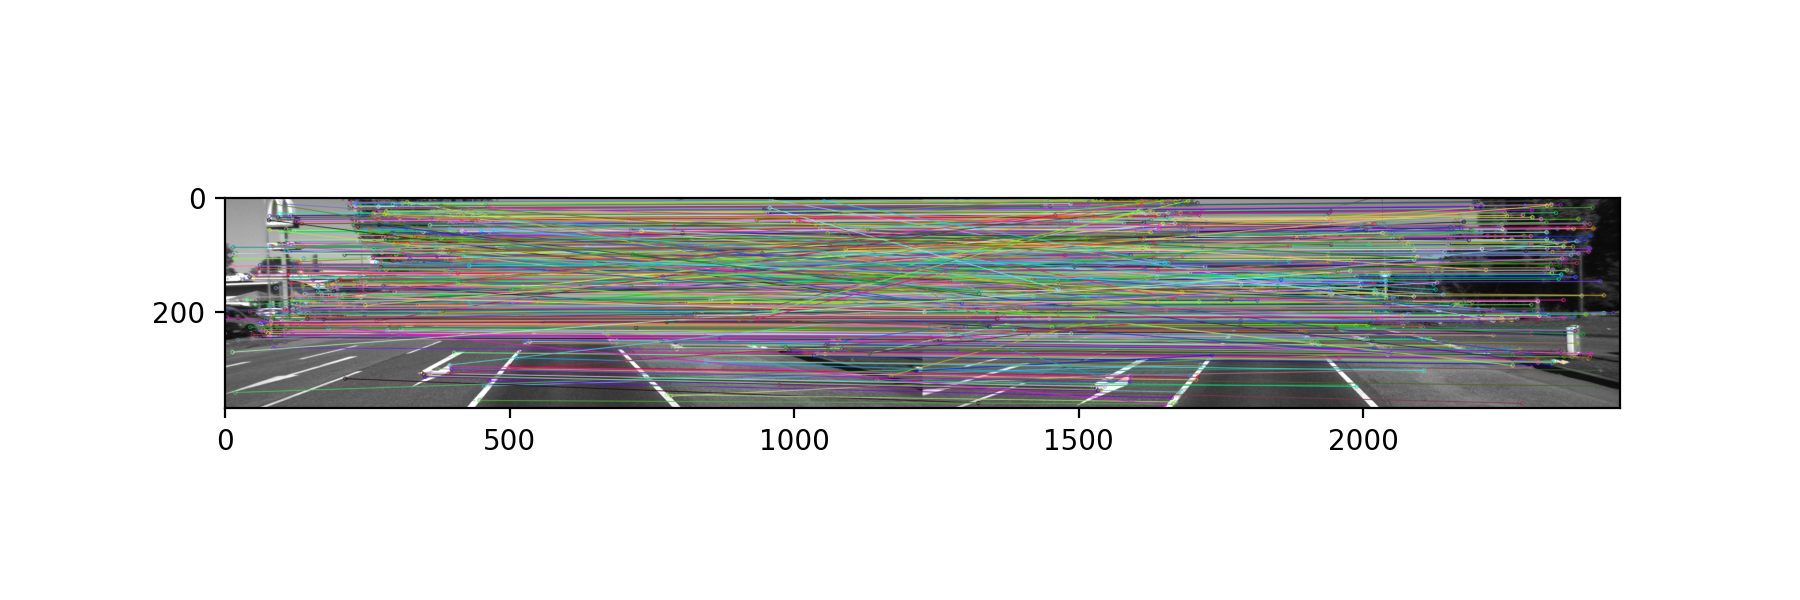

Keeping 558/1481 points that match the fundamental matrix
Keeping 214/550 new points, others weren't present in previous frame.
[[-9.99686988e-01 -8.81748178e-04  2.50029811e-02  1.35339020e-02]
 [ 6.67649850e-04 -9.99963054e-01 -8.56996745e-03 -4.12765977e-03]
 [ 2.50096139e-02 -8.55059171e-03  9.99650642e-01  9.74054393e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[1 0 0 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 0 1]]
Mean reprojection error: 533.9320265994398
Keeping 217/566 new points, others weren't present in previous frame.
[[-9.98006510e-01  2.57195476e-05  6.31110528e-02  3.29964730e-02]
 [-2.38687396e-04 -9.99994303e-01 -3.36695658e-03  1.79819654e-04]
 [ 6.31106067e-02 -3.37530840e-03  9.98000831e-01  9.47585340e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] [[-9.99686988e-01 -8.81748178e-04  2.50029811e-02  1.35339020e-02]
 [ 6.67649850e-04 -9.99963054e-01 -8.56996745e-03 -4.12765977e-03]
 [ 2.50096139e-02 -8.55059171e-03  9.99650

Keeping 168/462 new points, others weren't present in previous frame.
[[-0.85636718  0.0401531   0.51480384  0.23718794]
 [-0.05767178 -0.99817184 -0.0180817   0.00996017]
 [ 0.51313665 -0.04517423  0.8571173   0.56319487]
 [ 0.          0.          0.          1.        ]] [[ 0.89661046 -0.35968196  0.25829938  3.36444389]
 [ 0.37682871  0.92609906 -0.01845702 -0.25906386]
 [-0.23257215  0.11388338  0.96588859 12.17663107]
 [ 0.          0.          0.          1.        ]]
Mean reprojection error: 472.8914594061829
Keeping 170/470 new points, others weren't present in previous frame.
[[-0.84583253  0.04315149  0.53170036  0.24362641]
 [-0.06112623 -0.99799784 -0.01624498  0.01082711]
 [ 0.52993482 -0.04624137  0.84677673  0.5416389 ]
 [ 0.          0.          0.          1.        ]] [[-0.87242596  0.40383317  0.27530293  3.6141628 ]
 [-0.42364363 -0.9057217  -0.01393821 -0.14565721]
 [ 0.24371913 -0.12879039  0.96125648 12.73811849]
 [ 0.          0.          0.          1.        

In [8]:
# I made this part up, although it's an amalgamation of code from above which came from other places
# This cell is self-contained from a state perspective, but not a logic one
from itertools import islice

### Setup ###
K = kitti.calib.K_cam0
imgs = (np.array(img) for img in kitti.cam0)
ground_truth_poses = kitti.poses

img0 = next(imgs)
img1 = next(imgs)

points0, points1, matches, E = detect_matches_and_E(img0, img1)
# P0 is assumed to be fixed to start
P0 = np.array([
	[1, 0, 0, 0],
	[0, 1, 0, 0],
	[0, 0, 1, 0]
])
P1 = P_from_E(E)
Ps = [P0, P1]
Es = [E]
cur_pose = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
poses = [cur_pose]
point_cloud = PointCloud()
err = triangulate_points(1, point_cloud, points0, points1, K, P0, P1)




### Graph ###
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')
# for cp in point_cloud:
# 	ax.scatter(*cp.point3d)

# ax.set_title('First Round 3D Points')
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')
# plt.show()

### Run ###

for frame_id, img in enumerate(islice(imgs, 20), start=2):
	img0, img1 = img1, img
	points0, points1, matches, E = detect_matches_and_E(img0, img1, draw=False)
	Es.append(E)
	points1_valid = []

	for point0, point1 in zip(points0, points1):
		point3d = point_cloud.lookup2d(frame_id - 1, point0) 
		if point3d is not None:
			points1_valid.append((point3d, point1))
	
	print(f"Keeping {len(points1_valid)}/{len(points1)} new points, others weren't present in previous frame.")

	P0 = P1
	P1, R, t = P_from_PnP([point3d for point3d, _ in points1_valid], [point1 for _, point1 in points1_valid], K)
	Ps.append(P1)
	P1_fixed = np.vstack((P1, [0,0,0,1]))
	print(P1_fixed, cur_pose)
	cur_pose = (P1_fixed @ cur_pose)
	poses.append(cur_pose)

	err = triangulate_points(frame_id, point_cloud, points0, points1, K, P0, P1)
	print("Mean reprojection error:", err)

original_poses = poses

<IPython.core.display.Javascript object>


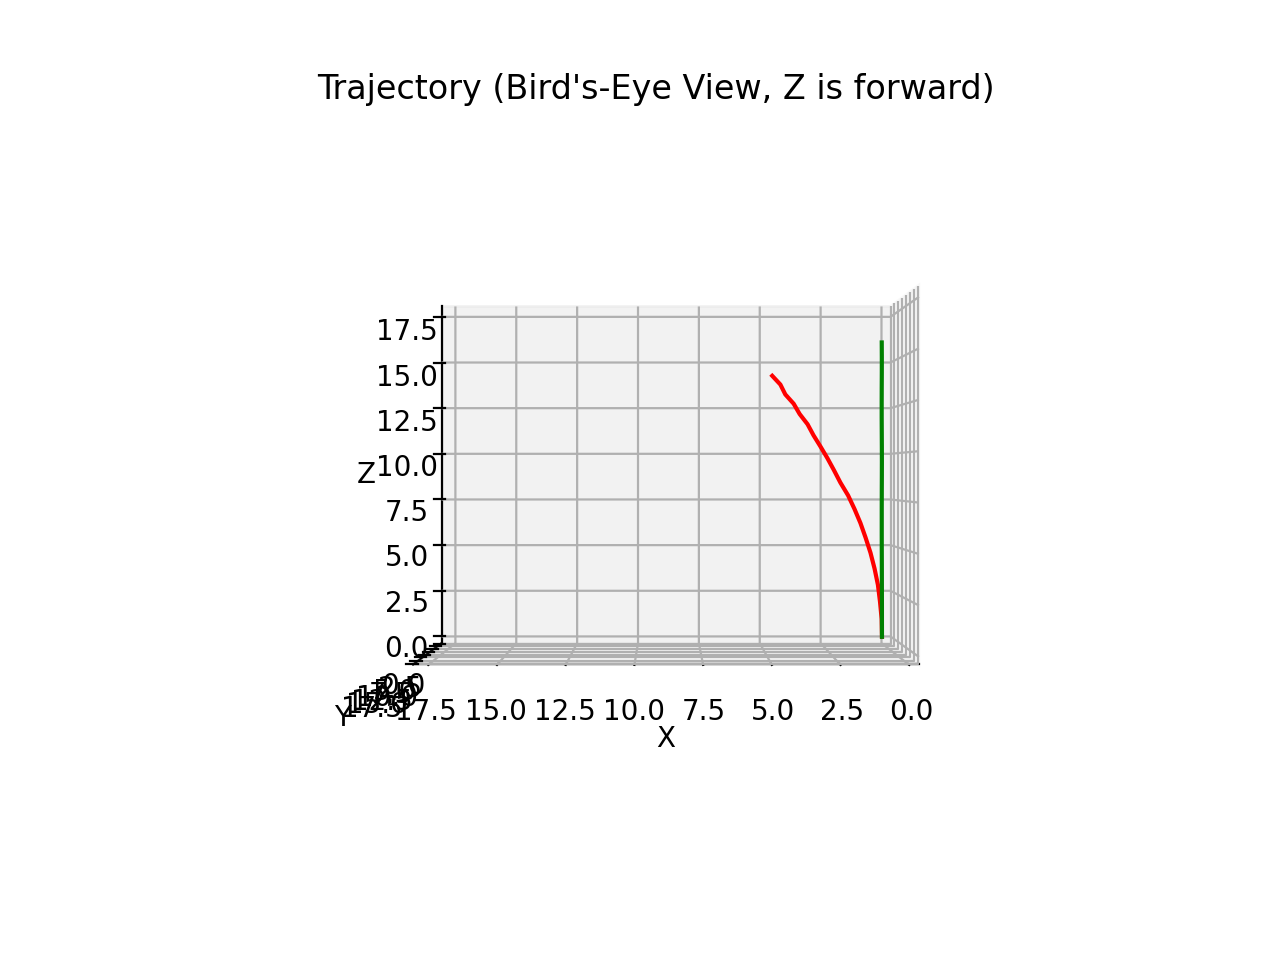

In [12]:
def plot_trajectory(ax, poses, scale_factor=1.0, line_color='r', arrow_color='b', arrow_size=5, arrow_prop=5):
    XYZ = np.array([P @ np.array([[0,0,0,1]]).transpose() for P in poses]).squeeze(axis=2)
    UVW = np.array([normalize(P @ np.array([[0,0,1,1]]).transpose()) * arrow_size for P in poses]).squeeze(axis=2)
    
    XYZ *= scale_factor
    UVW *= scale_factor

    MIN = 0
    MAX = np.max([np.max(XYZ), *ax.get_xlim(), *ax.get_ylim(), *ax.get_zlim()]) * 1.10

#     ax.quiver(
#         XYZ[::arrow_prop, 0], XYZ[::arrow_prop, 1], XYZ[::arrow_prop, 2],
#         UVW[::arrow_prop, 0], UVW[::arrow_prop, 1], UVW[::arrow_prop, 2], color=arrow_color)
    ax.plot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], line_color)

    ax.set_xlim(MIN, MAX)
    ax.set_ylim(MIN, MAX)
    ax.set_zlim(MIN, MAX)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
plot_trajectory(ax, poses)
plot_trajectory(ax, ground_truth_poses[:len(poses)], 0.60, 'g', 'g')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)
ax.set_title("Trajectory (Bird's-Eye View, Z is forward)")
plt.show()

## Bundle Adjustment
Based on this tutorial: https://scipy-cookbook.readthedocs.io/items/bundle_adjustment.html, but mostly re-written (except as otherwise marked).

<IPython.core.display.Javascript object>


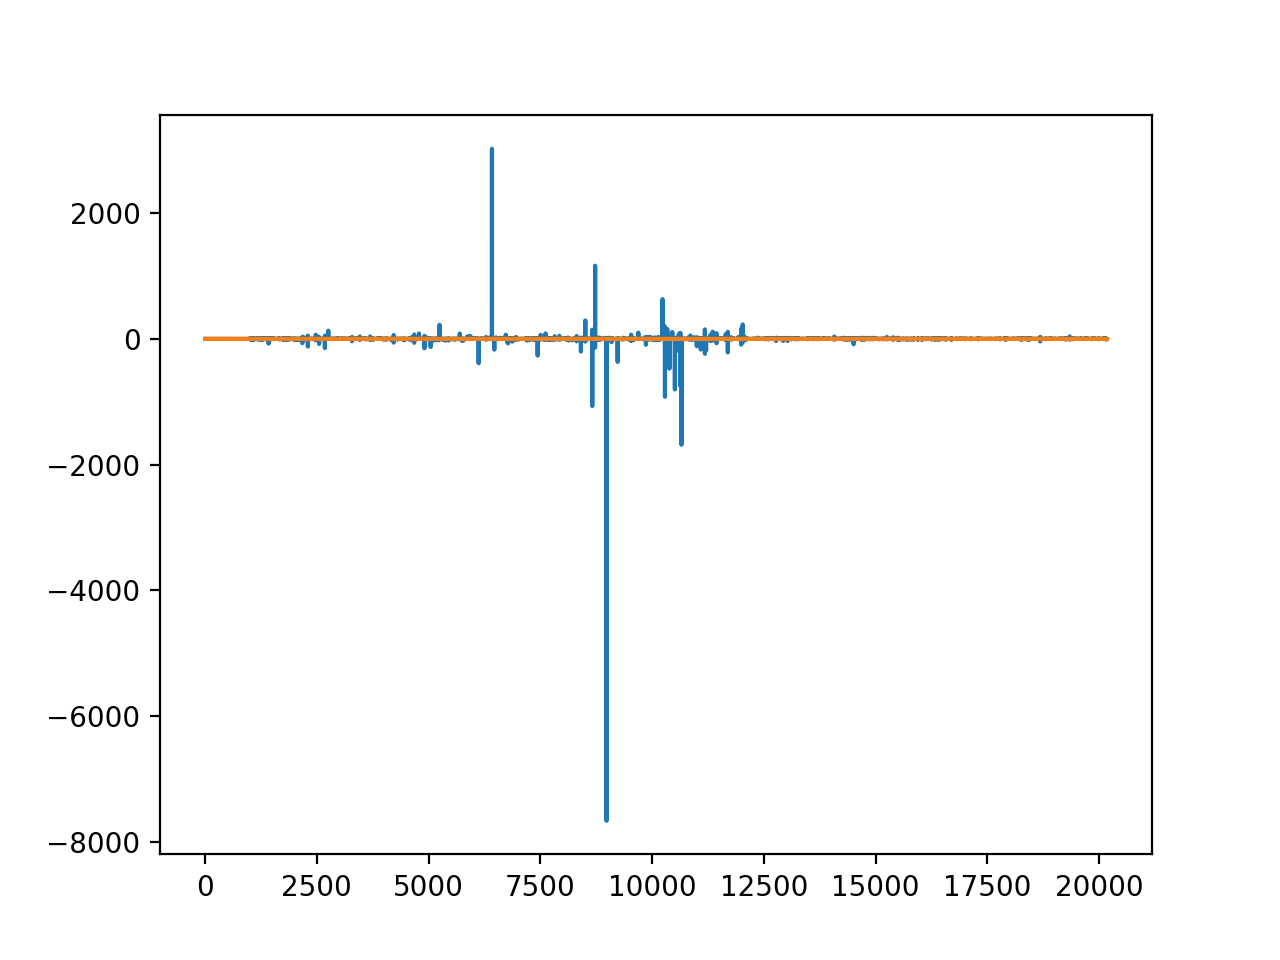

In [14]:
import time
import scipy

# K includes 5 dof which are constant for all frames:
# - translation (2 dof: cx, cy)
# - focal length/change of units (2 dof: fx/alpha, fy/beta)
# - skewness (1 dof: theta)
# R and t are provided on a per-frame basis (??? dof, does t overlap with translation in K?)

"""
Relevant data, in their implementation:
- camera_params with shape (n_cameras, 9) contains initial estimates of parameters for all cameras. First 3 components in each row form a rotation vector (https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula), next 3 components form a translation vector, then a focal distance and two distortion parameters.
- points_3d with shape (n_points, 3) contains initial estimates of point coordinates in the world frame.
- camera_ind with shape (n_observations,) contains indices of cameras (from 0 to n_cameras - 1) involved in each observation.
- point_ind with shape (n_observations,) contatins indices of points (from 0 to n_points - 1) involved in each observation.
- points_2d with shape (n_observations, 2) contains measured 2-D coordinates of points projected on images in each observations.
"""

FRAME_P_SIZE = 12
POINT3D_SIZE = 3

def residual(state, num_Ps, num_points3d, frame_idx, point3d_idx, points2d):
	frame_state_len = (num_Ps * FRAME_P_SIZE)
	frame_Ps = state[:frame_state_len].reshape((num_Ps, 3, 4))
	points3d = state[frame_state_len:].reshape((num_points3d, POINT3D_SIZE))

	P_by_frame = frame_Ps[frame_idx, :, :]
	point3d_by_frame = points3d[point3d_idx]
	point2d_by_frame = points2d
	# Add a 4th column to make homogenous multiplication work
	point3d_by_frame = np.hstack((point3d_by_frame, [[1]] * point3d_by_frame.shape[0]))

	# Credit to this SO answer for making the math work so nicely: https://stackoverflow.com/a/66971088
	# XXX: K should probably be passed as a parameter
	reprojected = np.einsum('kij,kj->ki', (K @ P_by_frame), point3d_by_frame)
	point2d_reproj = reprojected[:, :2] / reprojected[:, 2, None]

	return (point2d_reproj - point2d_by_frame).ravel()

frame_Ps = np.array(list(Ps))
points3d = np.array(list(point_cloud.points3d))
frame_idx = np.zeros((point_cloud.num_observations,), dtype=int)
point3d_idx = np.zeros((point_cloud.num_observations,), dtype=int)
points2d = np.zeros((point_cloud.num_observations, 2))

observation_id = 0
for point3d_id, point3d in enumerate(points3d):
	for frame_id, point2d in point_cloud.lookup3d(point3d):
		frame_idx[observation_id] = frame_id
		point3d_idx[observation_id] = point3d_id
		points2d[observation_id, :] = point2d
		observation_id += 1

state0 = np.hstack((frame_Ps.ravel(), points3d.ravel()))

residual0 = residual(state0, frame_Ps.shape[0], points3d.shape[0], frame_idx, point3d_idx, points2d)
plt.figure()
plt.plot(residual0)

In [15]:
from time import perf_counter
from scipy.optimize import least_squares
from scipy.sparse import lil_matrix

n_frames = frame_Ps.shape[0]
n_observations = points3d.shape[0]


### Generate Sparsity Matrix ###
# This logic is completely taken from the SciPy tutorial
resid_len = frame_idx.size * 2
state_len = (n_frames * FRAME_P_SIZE) + (n_observations * POINT3D_SIZE)
A = lil_matrix((resid_len, state_len), dtype=int)
i = np.arange(frame_idx.size)
for offset in range(FRAME_P_SIZE):
	A[2 * i, (frame_idx * FRAME_P_SIZE) + offset] = 1
	A[2 * i + 1, (frame_idx * FRAME_P_SIZE) + offset] = 1
for offset in range(POINT3D_SIZE):
	A[2 * i, (n_frames * FRAME_P_SIZE) + (point3d_idx * POINT3D_SIZE) + offset] = 1
	A[2 * i + 1, (n_frames * FRAME_P_SIZE) + (point3d_idx * POINT3D_SIZE) + offset] = 1

start_time = perf_counter()
res = least_squares(residual, state0, verbose=2, x_scale='jac', jac_sparsity=A, method='trf', args=(n_frames, n_observations, frame_idx, point3d_idx, points2d))
duration = perf_counter() - start_time
print(f"Bundle optimization took {duration:.2f} seconds.")

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.9397e+07                                    2.31e+11    
       1              2         4.6908e+06      3.47e+07       1.89e-01       1.91e+10    
       2              3         1.3108e+05      4.56e+06       5.00e-02       7.47e+08    
       3              4         4.9445e+01      1.31e+05       1.14e-02       8.14e+06    
       4              5         1.2929e-02      4.94e+01       3.82e-04       8.53e+03    
       5              6         1.7847e-09      1.29e-02       7.19e-06       3.17e+00    
       6              7         8.5667e-20      1.78e-09       2.69e-09       1.22e-04    
`xtol` termination condition is satisfied.
Function evaluations 7, initial cost 3.9397e+07, final cost 8.5667e-20, first-order optimality 1.22e-04.
Bundle optimization took 0.77 seconds.


<IPython.core.display.Javascript object>


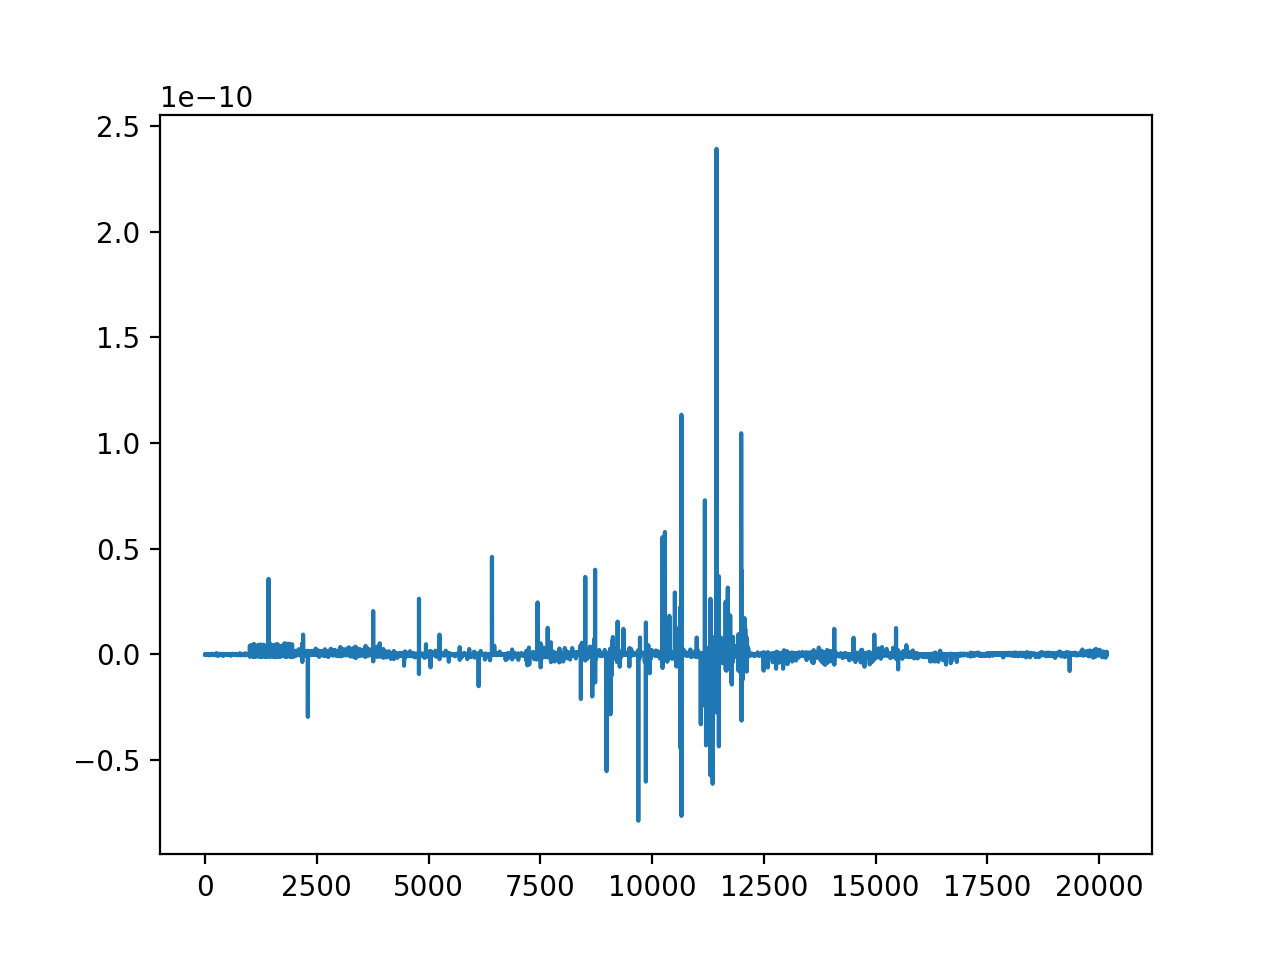

In [17]:
plt.figure()
plt.plot(res.fun)

In [18]:
Ps_flat = res.x[:(FRAME_P_SIZE * n_frames)]
points3d_flat = res.x[(FRAME_P_SIZE * n_frames):]

Ps = Ps_flat.reshape((n_frames, 3, 4))
points3d = points3d_flat.reshape((point_cloud.num_points3d, 3))

cur_pose = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0], [0,0,0,1]])
poses = [cur_pose]
for P in Ps:
	P_homogenous = np.vstack((P, [0,0,0,1]))
	cur_pose = P_homogenous @ cur_pose
	poses.append(cur_pose)


<IPython.core.display.Javascript object>


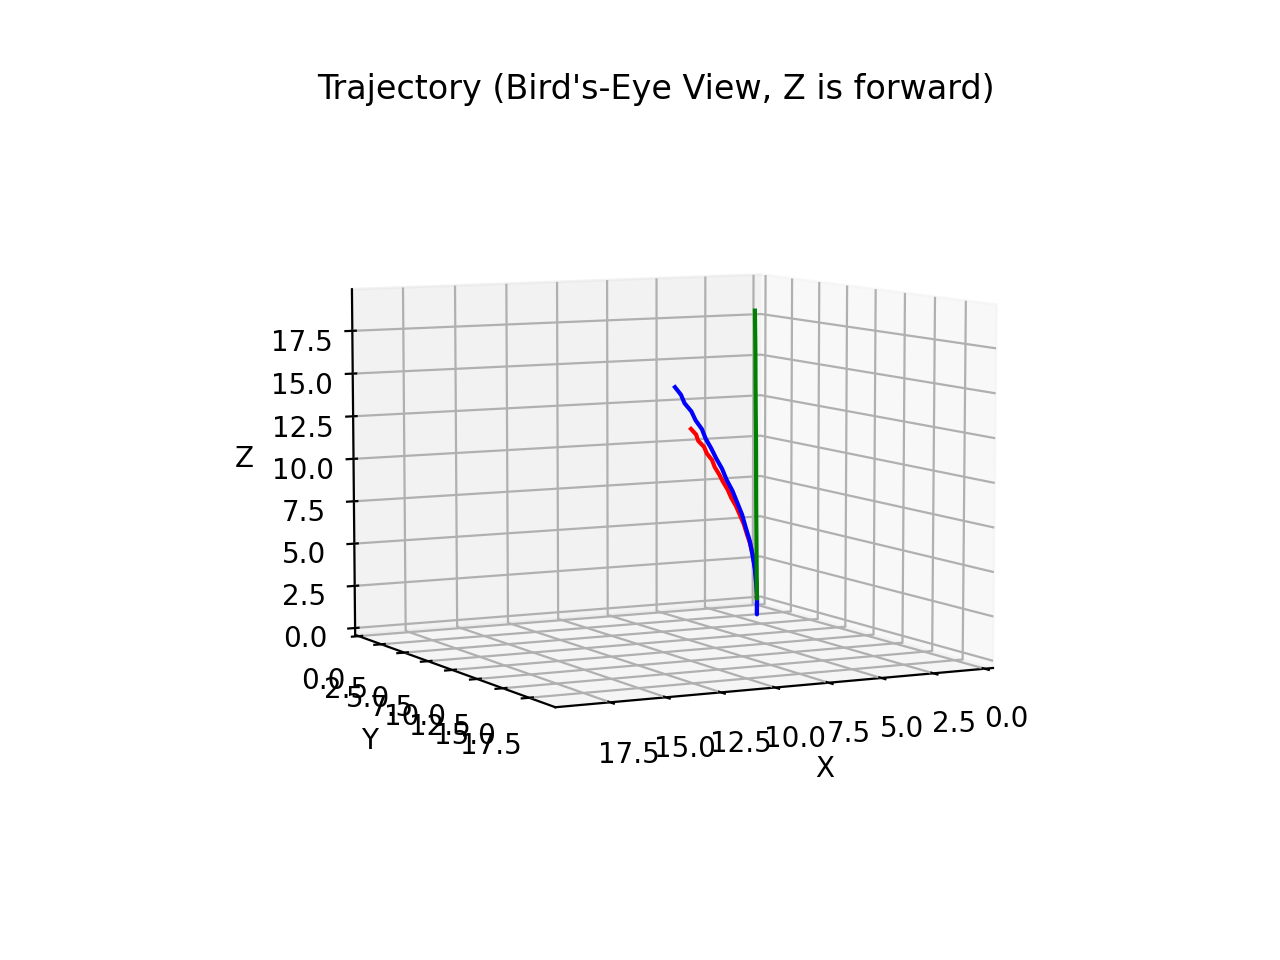

In [19]:
# Copied from above
def plot_trajectory(ax, poses, scale_factor=1.0, line_color='r', arrow_color='b', arrow_size=5, arrow_prop=5):
    XYZ = np.array([P @ np.array([[0,0,0,1]]).transpose() for P in poses]).squeeze(axis=2)
    UVW = np.array([normalize(P @ np.array([[0,0,1,1]]).transpose()) * arrow_size for P in poses]).squeeze(axis=2)
    
    XYZ *= scale_factor
    UVW *= scale_factor

    MIN = 0
    MAX = np.max([np.max(XYZ), *ax.get_xlim(), *ax.get_ylim(), *ax.get_zlim()]) * 1.10

#     ax.quiver(
#         XYZ[::arrow_prop, 0], XYZ[::arrow_prop, 1], XYZ[::arrow_prop, 2],
#         UVW[::arrow_prop, 0], UVW[::arrow_prop, 1], UVW[::arrow_prop, 2], color=arrow_color)
    ax.plot(XYZ[:, 0], XYZ[:, 1], XYZ[:, 2], line_color)

    ax.set_xlim(MIN, MAX)
    ax.set_ylim(MIN, MAX)
    ax.set_zlim(MIN, MAX)


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_zlim(0, 1)
plot_trajectory(ax, original_poses, .75, 'r', 'r')
plot_trajectory(ax, poses, 1, 'b', 'b')
plot_trajectory(ax, ground_truth_poses[:len(poses)], 0.60, 'g', 'g')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.view_init(0, 90)
ax.set_title("Trajectory (Bird's-Eye View, Z is forward)")
plt.show()

In [20]:
import time
from scipy.optimize import least_squares

"""
Relevant data:
- camera_params with shape (n_cameras, 9) contains initial estimates of parameters for all cameras. First 3 components in each row form a rotation vector (https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula), next 3 components form a translation vector, then a focal distance and two distortion parameters.
- points_3d with shape (n_points, 3) contains initial estimates of point coordinates in the world frame.
- camera_ind with shape (n_observations,) contains indices of cameras (from 0 to n_cameras - 1) involved in each observation.
- point_ind with shape (n_observations,) contatins indices of points (from 0 to n_points - 1) involved in each observation.
- points_2d with shape (n_observations, 2) contains measured 2-D coordinates of points projected on images in each observations.
"""

# TODO: Use rotation matrices instead
def rotate(points, rot_vecs):
    """
	Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.

	Copied from tutorial.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

def project(points, camera_params):
    """
    Convert 3-D points to 2-D by projecting onto images.
    
    Copied from tutorial.
    """
    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """
    Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.

    Copied from tutorial.
    """
    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    """
    Copied from tutorial.

    I think the idea here is that you're building a matrix of what correlates with what.

    In particular, certain 2d points (ie. certain values of m) only correlate with certain values in the state.
    """
    m = camera_indices.size * 2
    n = n_cameras * 12 + n_points * 3
    A = lil_matrix((m, n), dtype=int)
    i = np.arange(camera_indices.size)
    for s in range(12):
        A[2 * i,     camera_indices * 12 + s] = 1
        A[2 * i + 1, camera_indices * 12 + s] = 1
    for s in range(3):
        A[2 * i, n_cameras * 12 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 12 + point_indices * 3 + s] = 1
    return A

def run_bundle_adjustment():
    """ Copied from tutorial. """
    x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
    f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
    plt.plot(f0)
    A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)
    t0 = time.time()
    res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
    t1 = time.time()
    
    print("Optimization took {0:.0f} seconds".format(t1 - t0))
    plt.plot(res.fun)
